
#Import data

In [63]:
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, log_loss
from scipy.stats import zscore
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [42]:
df = pd.read_csv('/content/drive/MyDrive/maternal+health+risk/Maternal Health Risk Data Set.csv')
print(df.head(5))
print(df.info())


   Age  SystolicBP  DiastolicBP    BS  BodyTemp  HeartRate  RiskLevel
0   25         130           80  15.0      98.0         86  high risk
1   35         140           90  13.0      98.0         70  high risk
2   29          90           70   8.0     100.0         80  high risk
3   30         140           85   7.0      98.0         70  high risk
4   35         120           60   6.1      98.0         76   low risk
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1014 entries, 0 to 1013
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          1014 non-null   int64  
 1   SystolicBP   1014 non-null   int64  
 2   DiastolicBP  1014 non-null   int64  
 3   BS           1014 non-null   float64
 4   BodyTemp     1014 non-null   float64
 5   HeartRate    1014 non-null   int64  
 6   RiskLevel    1014 non-null   object 
dtypes: float64(2), int64(4), object(1)
memory usage: 55.6+ KB
None


In [43]:

#drop duplicate values
df = df.drop_duplicates(ignore_index=True)
print("Number of rows after dropping duplicates:", df.shape[0])
# Count of NaN values in each column
nan_counts = df.isnull().sum()

# Filter columns with at least one NaN value
columns_with_nan = nan_counts[nan_counts > 0].index.tolist()

if len(columns_with_nan) == 0:
  print("no column with NAN values")
else:
  print(columns_with_nan)


Number of rows after dropping duplicates: 452
no column with NAN values


#Univariate Analysis

In [44]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,452.0,29.194690,13.767379,10.0,19.0,25.0,35.0,70.0
SystolicBP,452.0,110.553097,17.872282,70.0,90.0,120.0,120.0,160.0
DiastolicBP,452.0,75.418142,13.754578,49.0,65.0,80.0,86.0,100.0
BS,452.0,8.346173,2.829209,6.0,6.9,7.5,7.9,19.0
BodyTemp,452.0,98.692478,1.410897,98.0,98.0,98.0,98.0,103.0
HeartRate,452.0,73.949115,8.156973,7.0,70.0,76.0,80.0,90.0


In [45]:
def num_plot(df, col):
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    cmap = plt.get_cmap('Blues')
    risk_order = ['low risk', 'mid risk', 'high risk'] # Example order
    p_colors = {'low risk': cmap(0.2), 'mid risk':cmap(0.5) , 'high risk': cmap(0.9)}


    sns.histplot(data=df, x=col, kde=True, ax=ax[0],hue='RiskLevel', hue_order=risk_order, palette=p_colors)
    sns.boxplot(data=df, x=col, ax=ax[1])
    ax[0].set_title(f"{col} Distribution Histogram")
    ax[1].set_title(f"{col} Distribution Boxplot")

    plt.show()


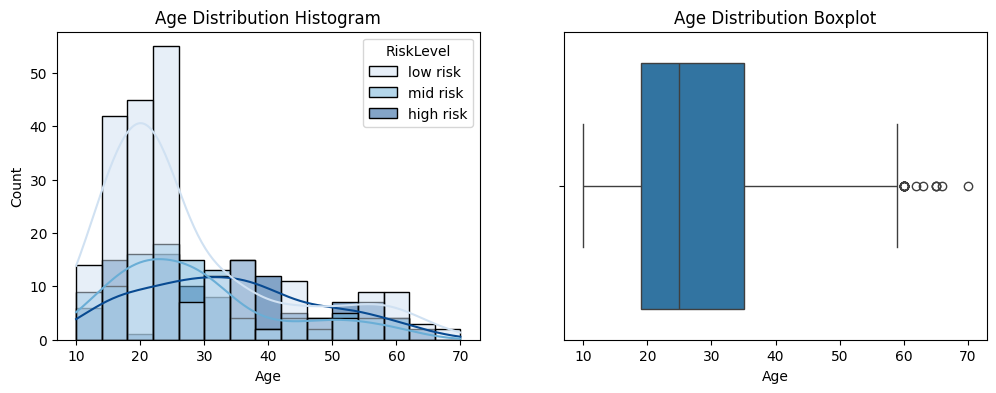

In [46]:
num_plot(df, "Age")

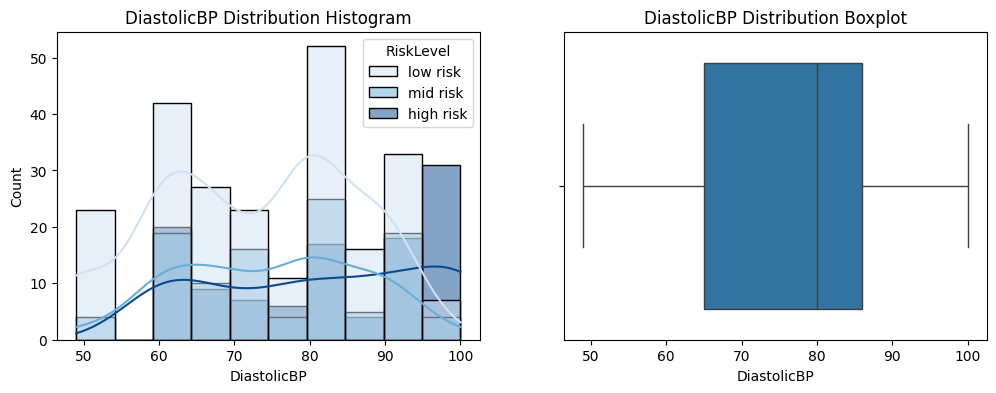

In [47]:
num_plot(df, "DiastolicBP")

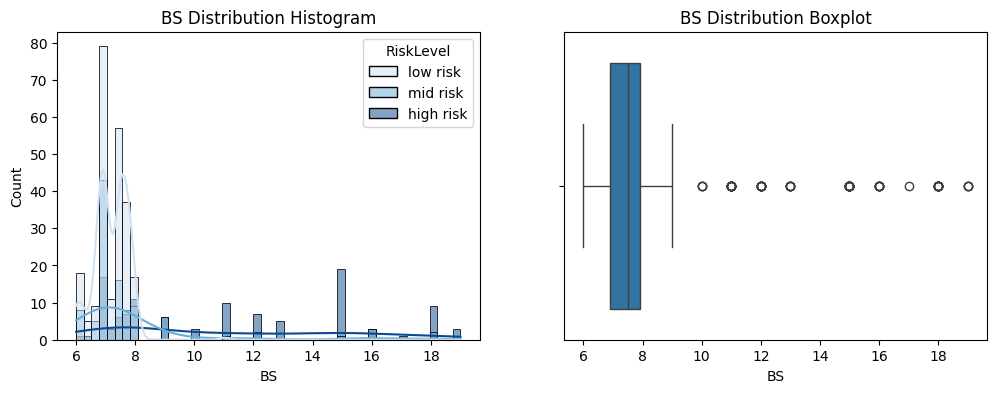

In [48]:
num_plot(df, "BS")

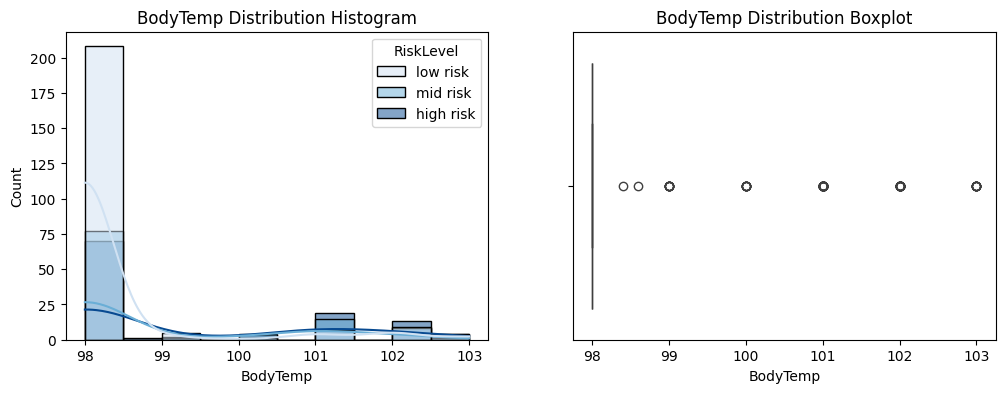

In [49]:
num_plot(df, "BodyTemp")

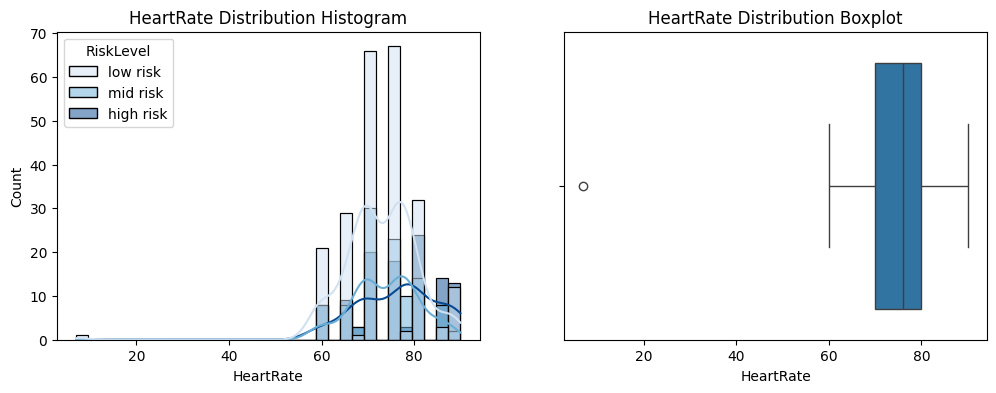

In [50]:
num_plot(df, "HeartRate")

In [51]:
numeric_cols = ['Age', 'SystolicBP', 'DiastolicBP', 'BS', 'BodyTemp', 'HeartRate']
df[numeric_cols] = df[numeric_cols].apply(zscore)

# Display Z-scores (optional, to verify the calculation)
print(df)


          Age  SystolicBP  DiastolicBP        BS  BodyTemp  HeartRate  \
0   -0.305021    1.089310     0.333484  2.354439 -0.491351   1.479009   
1    0.422139    1.649455     1.061321  1.646744 -0.491351  -0.484676   
2   -0.014157   -1.151273    -0.394352 -0.122492  0.927758   0.742627   
3    0.058559    1.649455     0.697402 -0.476340 -0.491351  -0.484676   
4    0.422139    0.529164    -1.122188 -0.794802 -0.491351   0.251706   
..        ...         ...          ...       ...       ...        ...   
447 -1.250328   -0.591127    -1.850025 -0.688648 -0.491351  -0.484676   
448 -1.032180   -0.591127    -1.122188 -0.830187 -0.491351   0.742627   
449 -1.032180   -0.591127    -1.922808 -0.264031 -0.491351   0.374436   
450 -1.250328   -0.591127    -1.850025 -0.830187 -0.491351  -0.484676   
451 -0.595885   -0.591127    -1.850025 -0.547109 -0.491351  -1.711980   

     RiskLevel  
0    high risk  
1    high risk  
2    high risk  
3    high risk  
4     low risk  
..         ...  
447 

In [52]:
threshold = 2.5
numeric_cols = [ 'SystolicBP', 'DiastolicBP', 'HeartRate']
# Filter the DataFrame
df_filtered = df[( df[numeric_cols].abs()< threshold).all(axis=1)]

# Reset index after filtering
df_filtered.reset_index(drop=True, inplace=True)

# Show the filtered DataFrame
print("DataFrame without outliers:\n", df_filtered)

DataFrame without outliers:
           Age  SystolicBP  DiastolicBP        BS  BodyTemp  HeartRate  \
0   -0.305021    1.089310     0.333484  2.354439 -0.491351   1.479009   
1    0.422139    1.649455     1.061321  1.646744 -0.491351  -0.484676   
2   -0.014157   -1.151273    -0.394352 -0.122492  0.927758   0.742627   
3    0.058559    1.649455     0.697402 -0.476340 -0.491351  -0.484676   
4    0.422139    0.529164    -1.122188 -0.794802 -0.491351   0.251706   
..        ...         ...          ...       ...       ...        ...   
445 -1.250328   -0.591127    -1.850025 -0.688648 -0.491351  -0.484676   
446 -1.032180   -0.591127    -1.122188 -0.830187 -0.491351   0.742627   
447 -1.032180   -0.591127    -1.922808 -0.264031 -0.491351   0.374436   
448 -1.250328   -0.591127    -1.850025 -0.830187 -0.491351  -0.484676   
449 -0.595885   -0.591127    -1.850025 -0.547109 -0.491351  -1.711980   

     RiskLevel  
0    high risk  
1    high risk  
2    high risk  
3    high risk  
4     low

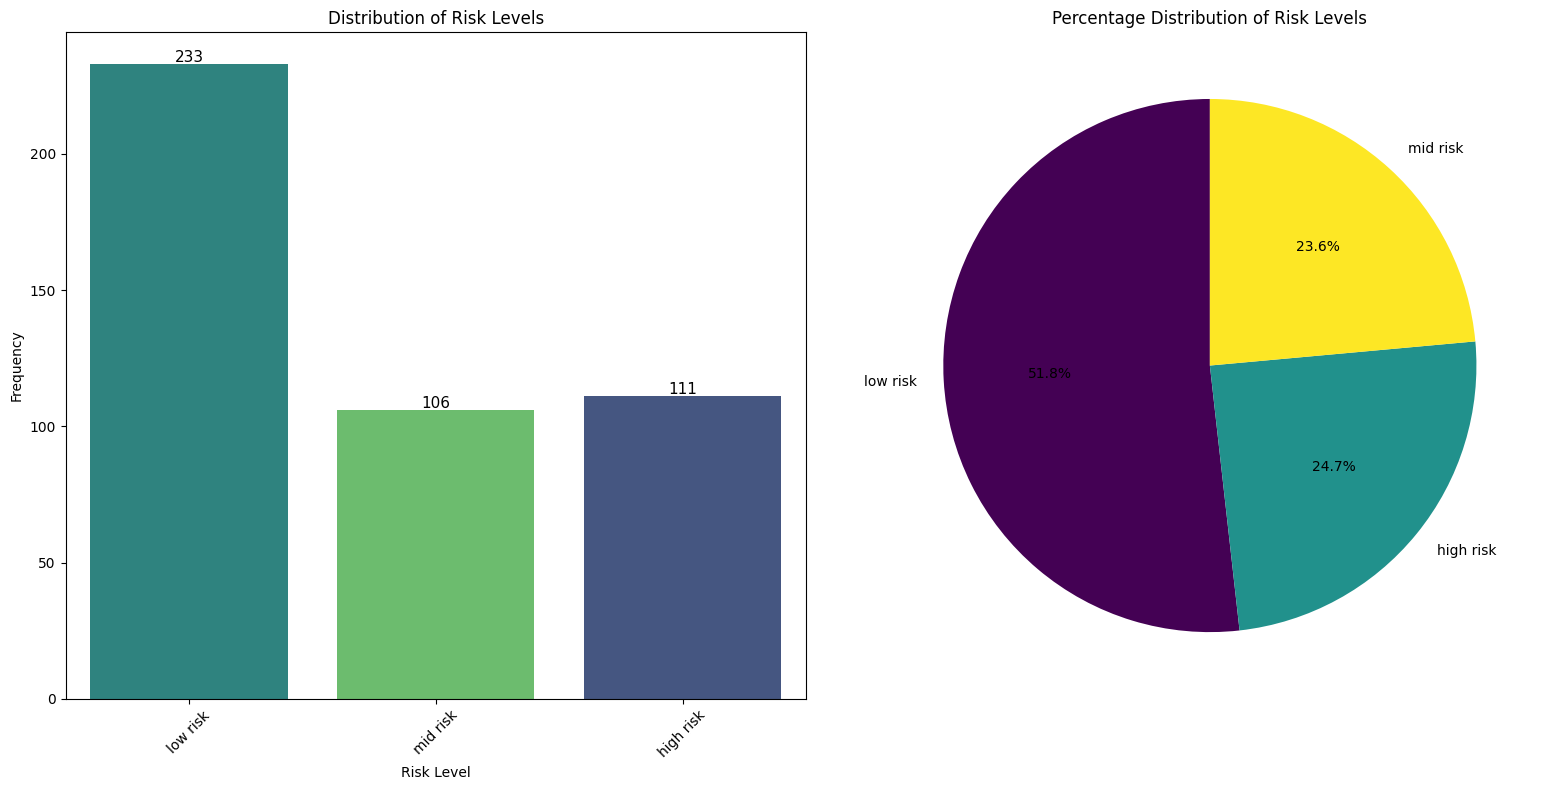

In [53]:
custom_order = ['low risk', 'mid risk', 'high risk']
label_counts = df_filtered['RiskLevel'].value_counts()

plt.figure(figsize=(16, 8))  # Set the overall figure size

# First subplot for bar chart
plt.subplot(1, 2, 1)
ax = sns.countplot(x='RiskLevel', hue='RiskLevel', data=df_filtered, order=custom_order, palette='viridis')
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=11, color='black', xytext=(0, 5), textcoords='offset points')
plt.xlabel('Risk Level')
plt.ylabel('Frequency')
plt.title('Distribution of Risk Levels')
plt.xticks(rotation=45)

# Second subplot for pie chart
plt.subplot(1, 2, 2)
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=90, colors=plt.cm.viridis(np.linspace(0, 1, len(label_counts))))
plt.title('Percentage Distribution of Risk Levels')

plt.tight_layout()  # Adjusts subplot params so that subplots are nicely fit in the figure area
plt.show()


#Bivariate Analysis

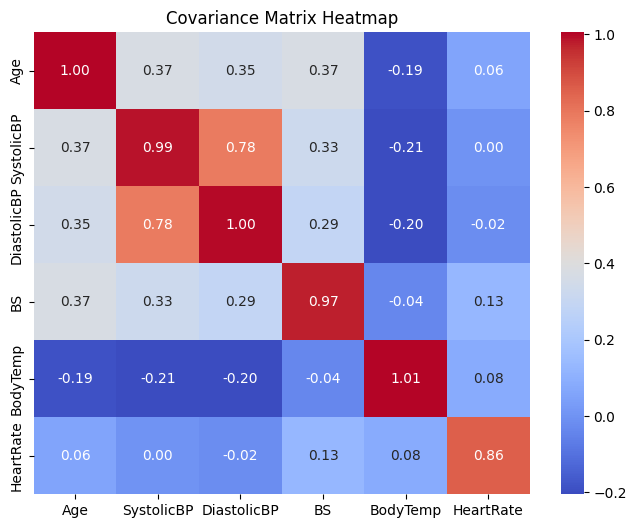

In [54]:
df_scaled = df_filtered.drop(columns=['RiskLevel'])
cov_matrix = df_scaled.cov()
plt.figure(figsize=(8, 6))
sns.heatmap(cov_matrix, annot=True, fmt='.2f', cmap='coolwarm', cbar=True)
plt.title('Covariance Matrix Heatmap')
plt.show()

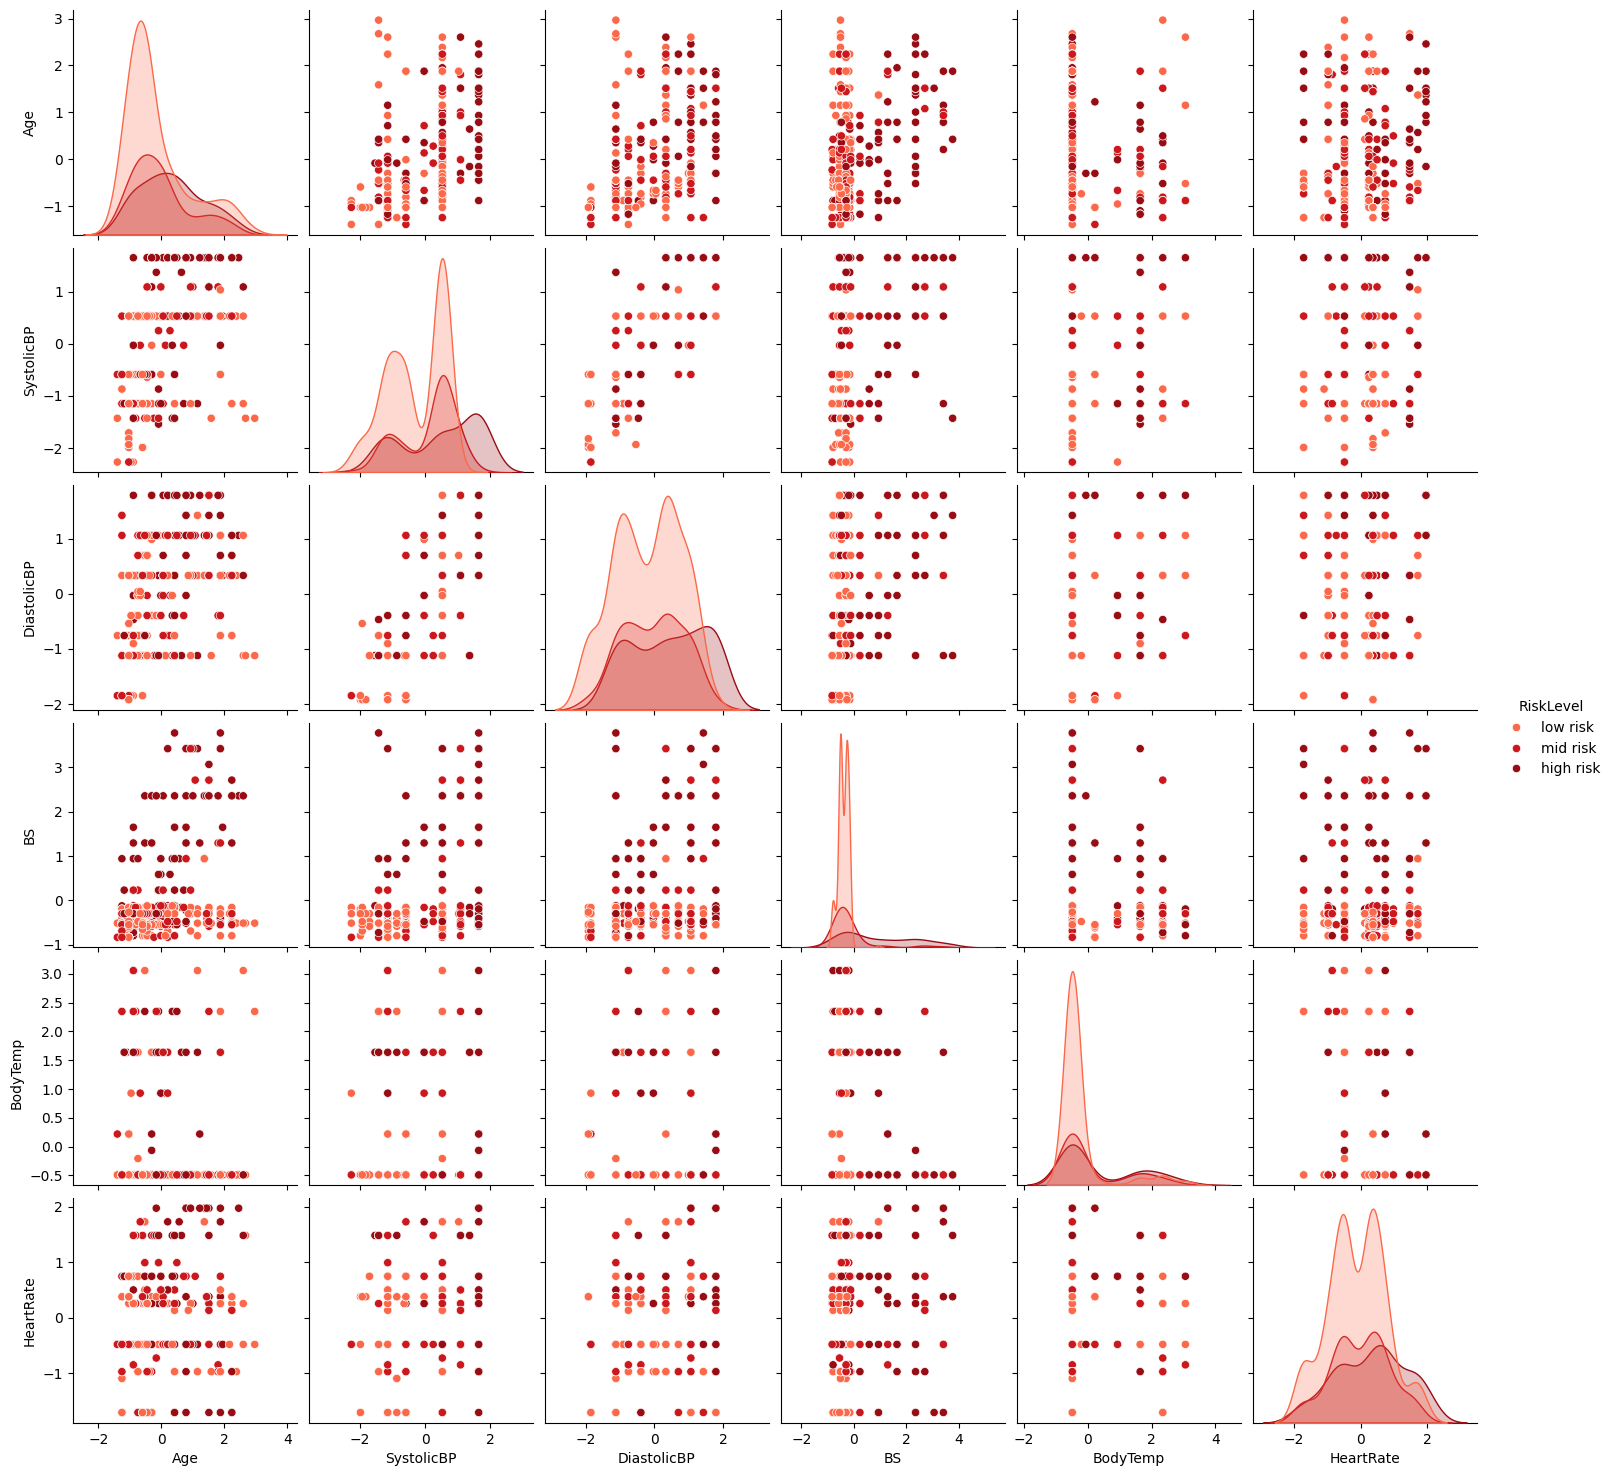

In [55]:
cmap = plt.get_cmap('Reds')
risk_order = ['low risk', 'mid risk', 'high risk'] # Example order
p_colors = {'low risk': cmap(0.5), 'mid risk':cmap(0.75) , 'high risk': cmap(0.9)} # Example palette
sns.pairplot(df_filtered, hue='RiskLevel', hue_order=risk_order, palette=p_colors)
plt.show()

#Feature Selection

Linear Regression Coefficients:
Age           -0.031546
SystolicBP     0.205985
DiastolicBP   -0.005963
BS             0.399149
BodyTemp       0.261963
HeartRate      0.072422
dtype: float64


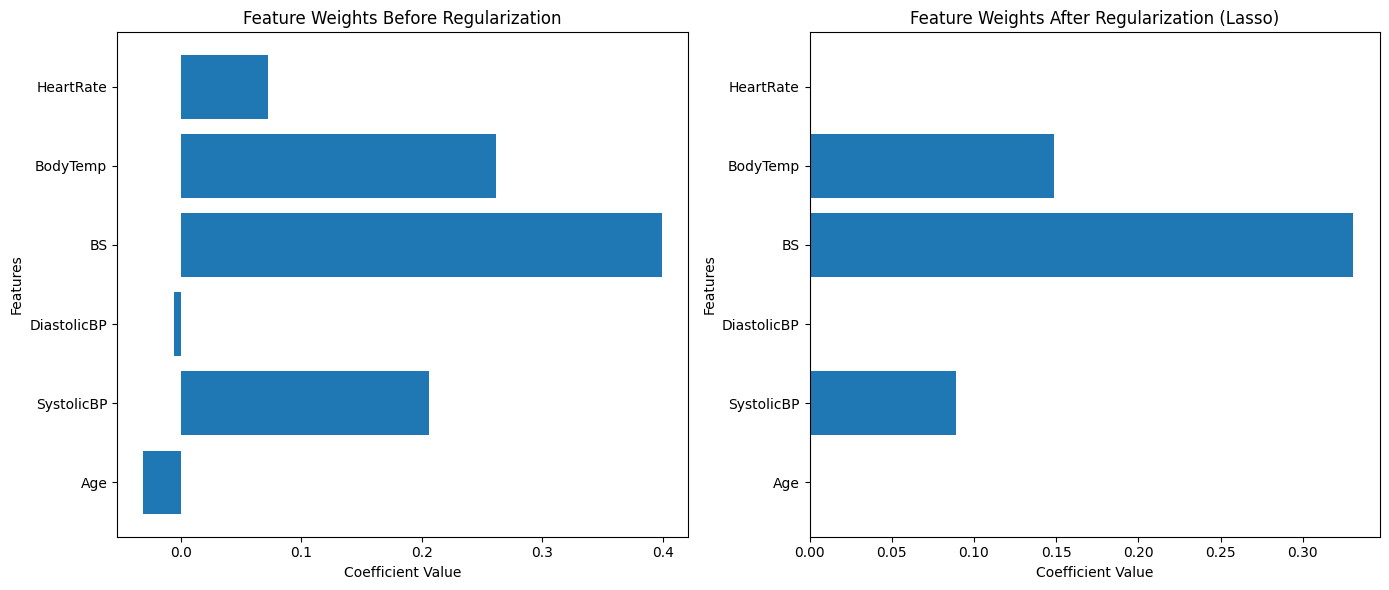

In [56]:
# Mapping RiskLevel to numeric values
risk_mapping = {'low risk': 0, 'mid risk': 1, 'high risk': 2}
#df_filtered['RiskLevel'] = df_filtered['RiskLevel'].map(risk_mapping)

# Handling any potential typos in the RiskLevel column
df_filtered = df_filtered.dropna(subset=['RiskLevel'])

# Features and target variable
X = df_filtered.drop(columns='RiskLevel')
y = df_filtered['RiskLevel'].map(risk_mapping)
# Standardizing the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
# Fit Linear Regression model (before regularization)
linear_model = LinearRegression()
linear_model.fit(X_scaled, y)
linear_coefficients = pd.Series(linear_model.coef_, index=X.columns)

# Apply Lasso Regression (after regularization)
lasso = Lasso(alpha=0.1)  # Alpha is the regularization strength
lasso.fit(X_scaled, y)
lasso_coefficients = pd.Series(lasso.coef_, index=X.columns)

# Plotting the coefficients before and after regularization
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Before regularization
ax[0].barh(X.columns, linear_coefficients)
ax[0].set_title('Feature Weights Before Regularization')
ax[0].set_xlabel('Coefficient Value')
ax[0].set_ylabel('Features')

# After regularization
ax[1].barh(X.columns, lasso_coefficients)
ax[1].set_title('Feature Weights After Regularization (Lasso)')
ax[1].set_xlabel('Coefficient Value')
ax[1].set_ylabel('Features')

# Print the coefficients to inspect the differences
print("Linear Regression Coefficients:")
print(linear_coefficients)

plt.tight_layout()
plt.show()


In [57]:
X = X.drop(columns=['Age','DiastolicBP'])

#Model Selection

In [64]:
X_1, X_test, y_1, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_cross, y_train, y_cross = train_test_split(X_1, y_1, test_size=0.2, random_state=42)
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)


KNN:
Average Accuracy: 0.6600
Average Weighted F1 Score: 0.6217


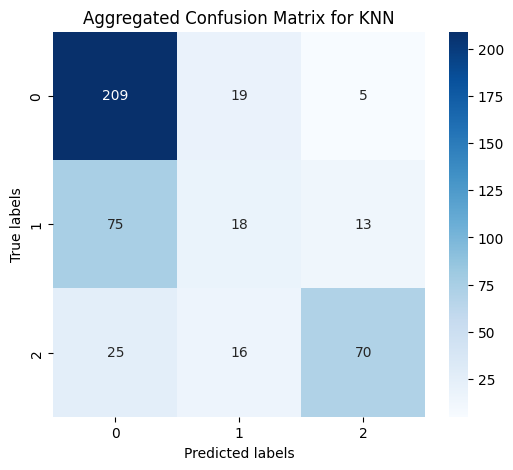

SVM:
Average Accuracy: 0.6200
Average Weighted F1 Score: 0.5477


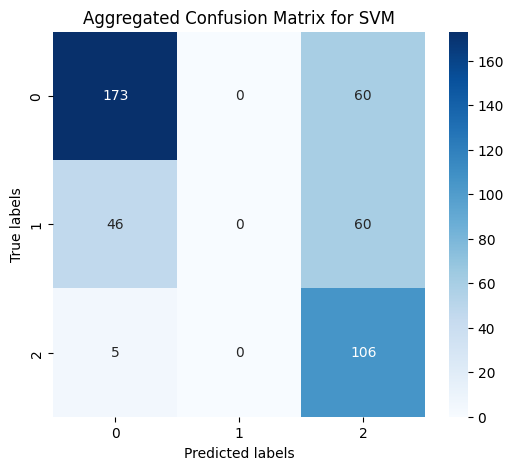

Random Forest:
Average Accuracy: 0.6200
Average Weighted F1 Score: 0.6102


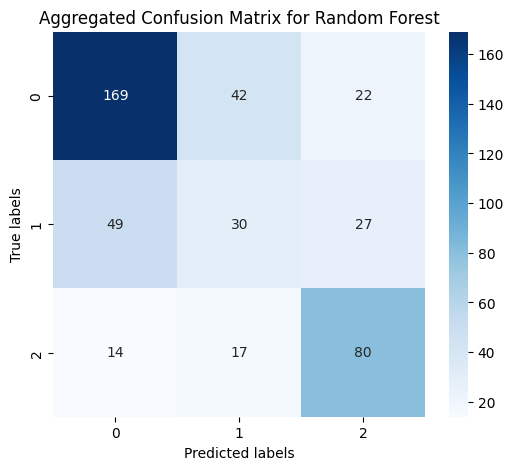

MLP:
Average Accuracy: 0.6911
Average Weighted F1 Score: 0.6299


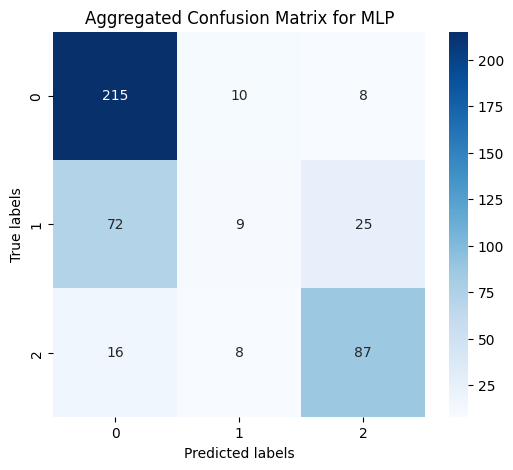

XGBoost:
Average Accuracy: 0.6289
Average Weighted F1 Score: 0.6163


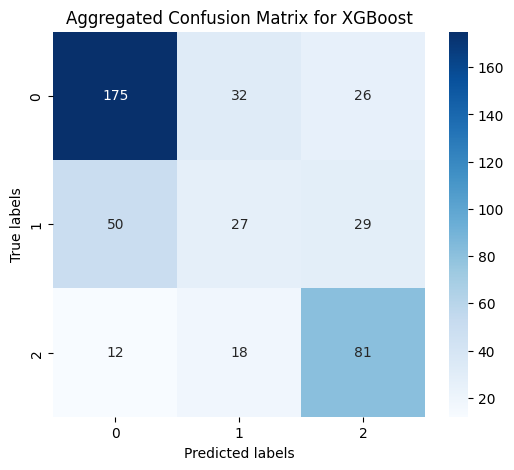

In [65]:
# Initialize results storage
results = {name: {'Accuracy': [], 'Weighted F1 Score': [], 'Confusion Matrices': []} for name in models}

# Iterate over each fold
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Apply class weight adjustment for XGBoost or generate weights array
    weights = y_train.apply(lambda x: 10 if x == 2 else 1).values

    # Train and evaluate each model
    for name, model in models.items():
        if name == 'XGBoost':
            model.fit(X_train, y_train, sample_weight=weights)
        else:
            model.fit(X_train, y_train)

        y_pred = model.predict(X_test)

        # Calculate metrics
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')
        cm = confusion_matrix(y_test, y_pred)

        # Store results
        results[name]['Accuracy'].append(acc)
        results[name]['Weighted F1 Score'].append(f1)
        results[name]['Confusion Matrices'].append(cm)

# Print and plot final aggregated results
for name in models:
    avg_acc = np.mean(results[name]['Accuracy'])
    avg_f1 = np.mean(results[name]['Weighted F1 Score'])
    print(f"{name}:")
    print(f"Average Accuracy: {avg_acc:.4f}")
    print(f"Average Weighted F1 Score: {avg_f1:.4f}")

    # Aggregate confusion matrices
    aggregate_cm = np.sum(results[name]['Confusion Matrices'], axis=0)
    plt.figure(figsize=(6, 5))
    sns.heatmap(aggregate_cm, annot=True, fmt='g', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title(f'Aggregated Confusion Matrix for {name}')
    plt.show()


Best model based on weighted F1 score: MLP
Final Evaluation of MLP
Weighted F1 Score: 0.6007
Accuracy: 0.6444


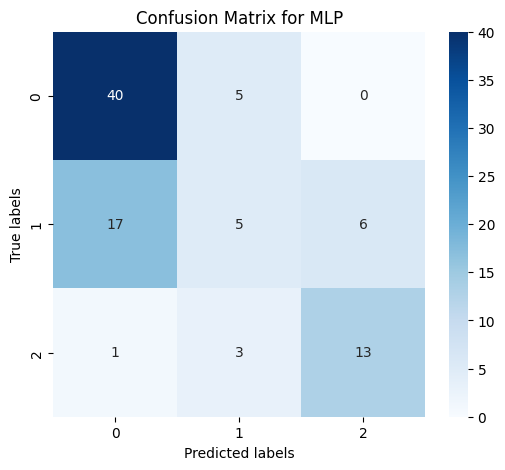

In [68]:
# Assuming 'results' dictionary stores average F1 scores in the following way:
# results = {'ModelName': {'Accuracy': [], 'Weighted F1 Score': [], 'Confusion Matrices': []}}

# Calculate average F1 scores for each model and determine the best model
average_f1_scores = {name: np.mean(info['Weighted F1 Score']) for name, info in results.items()}
best_model_name = max(average_f1_scores, key=average_f1_scores.get)
best_model = models[best_model_name]

print(f"Best model based on weighted F1 score: {best_model_name}")

# Re-training the best model on the full training data for final evaluation (Optional: Use the entire dataset or just keep a separate test set)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
best_model.fit(X_train, y_train)

# Final evaluation of the chosen model on the test set
y_pred_final = best_model.predict(X_test)
final_f1 = f1_score(y_test, y_pred_final, average='weighted')
final_cm = confusion_matrix(y_test, y_pred_final)
final_acc = accuracy_score(y_test, y_pred_final)

print(f"Final Evaluation of {best_model_name}")
print(f"Weighted F1 Score: {final_f1:.4f}")
print(f"Accuracy: {final_acc:.4f}")

# Plot the final confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(final_cm, annot=True, fmt='g', cmap='Blues', xticklabels=best_model.classes_, yticklabels=best_model.classes_)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title(f'Confusion Matrix for {best_model_name}')
plt.show()
